In [1]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm
 
import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

[2023-11-15 00:36:58] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2023-11-15 00:36:58] WARNING - __init__.py - Failed to import pytorch_quantization


The console stream is logged into /home/storonkin/sg_logs/console.log


[2023-11-15 00:36:59] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-11-15 00:36:59] WARNING - export.py - Failed to import pytorch_quantization
[2023-11-15 00:36:59] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [2]:
import os
HOME = os.getcwd()
CHECKPOINT_DIR = f'{HOME}/checkpoints'
LOCATION = "/media/storonkin/Work/datasets/dataset_target_1"
BATCH_SIZE = 16
EPOCHS = 50
WORKERS = 20

dataset_params = {
    'data_dir': LOCATION,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['person','weapon']
}



In [3]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)
 
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

[2023-11-15 00:36:59] WARNING - yolo_format_detection.py - 6 images are note associated to any label file
[2023-11-15 00:36:59] WARNING - yolo_format_detection.py - 7417 label files are not associated to any image.
[2023-11-15 00:36:59] WARNING - yolo_format_detection.py - As a consequence, 29590/29596 images and 29590/37007 label files will be used.
[2023-11-15 00:36:59] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 29590/29590 [00:04<00:00, 6023.78it/s]
[2023-11-15 00:37:04] WARNING - detection_dataset.py - Found 81 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.
[2023-11-15 00:37:04] WARNING - yolo_format_detection.py - 2148 label files are not associated to any image.
[2023-11-15 00:37:04] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes 

In [4]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [5]:
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [6]:
train_data.dataset.transforms.pop(0)

DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114)

In [7]:
train_data.dataset.transforms.pop(0)

DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114)

In [8]:
train_data.dataset.transforms

[DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_empty_targets': False, 'swap': (2, 0, 1), 'input_dim': (640, 640), 'pad_value': 114),
 DetectionTargetsFormatTransform('additional_samples_count': 0, 'non_empty_targets': False, 'input_format': OrderedDict([('bboxes', name=bboxes length=4 format=<super_gradients.training.datasets.data_formats.bbox_formats.xyxy.XYXYCoordinateFormat object at 0x7f6c14dc8ca0>), ('labels', name=labels length=1)]), 'output_format': OrderedDict([('labels', name=labels length=1), ('bboxes', name=bboxes length=4 format=<super_gradients.training.datasets.data_formats.bbox_formats.cxcywh.CXCYWHCoordinateFormat object at 0x7f6c14dcba00>)]), 'min_bbox_edge_size': 1, 'input

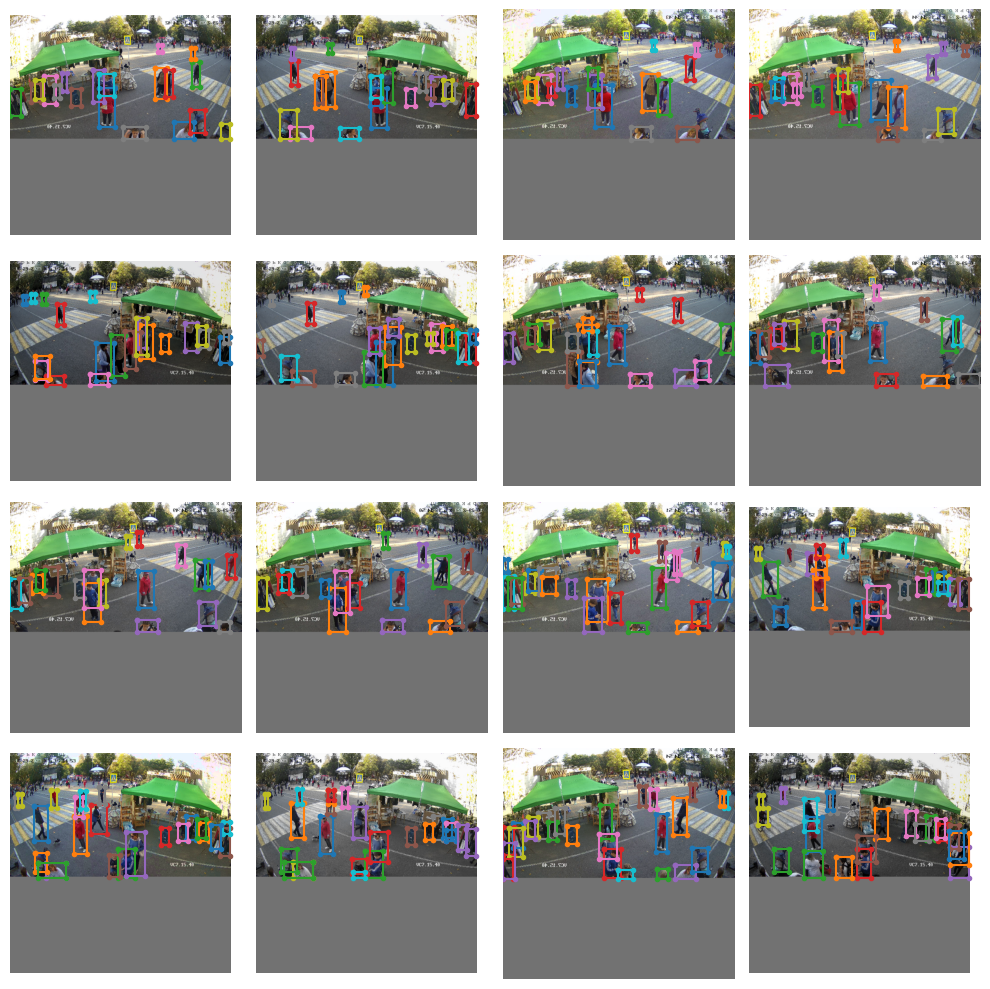

In [9]:
train_data.dataset.plot(plot_transformed_data=True)

In [10]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.5,
            top_k_predictions=100,
            include_classwise_ap=True ,    
        calc_best_score_thresholds=True ,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.5,
            top_k_predictions=100,
            num_cls=len(dataset_params['classes']),
              include_classwise_ap=True ,    
        calc_best_score_thresholds=True ,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

[2023-11-15 00:37:29] WARNING - detection_metrics.py - Parameter 'include_classwise_ap' is set to True, but no class names are provided. We will generate dummy class names, but we recommend to provide class names explicitly tohave meaningful names in reported metrics.
[2023-11-15 00:37:29] WARNING - detection_metrics.py - Parameter 'include_classwise_ap' is set to True, but no class names are provided. We will generate dummy class names, but we recommend to provide class names explicitly tohave meaningful names in reported metrics.


In [11]:
CHECKPOINT_DIR = 'checkpoints'
model_to_train = "yolo_nas_s"

trainer = Trainer(
    experiment_name=model_to_train, 
    ckpt_root_dir=CHECKPOINT_DIR
)

model = models.get(
    model_to_train, 
    num_classes=len(dataset_params['classes']), 
    checkpoint_path="/media/storonkin/Work/projects/we-love-you-all/notebooks/checkpoints/yolo_nas_s/RUN_20231114_214443_597005/ckpt_best.pth"
).cuda()

trainer.train(
    model=model, 
    training_params=train_params, 
    train_loader=train_data, 
    valid_loader=val_data
)

[2023-11-15 00:37:31] INFO - checkpoint_utils.py - Successfully loaded model weights from /media/storonkin/Work/projects/we-love-you-all/notebooks/checkpoints/yolo_nas_s/RUN_20231114_214443_597005/ckpt_best.pth EMA checkpoint.
[2023-11-15 00:37:32] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231115_003732_749383`
[2023-11-15 00:37:32] INFO - sg_trainer.py - Checkpoints directory: checkpoints/yolo_nas_s/RUN_20231115_003732_749383
2023-11-15 00:37:32.933302: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 00:37:33.023208: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 00:37:33.023231: E tensorflow/com

The console stream is now moved to checkpoints/yolo_nas_s/RUN_20231115_003732_749383/console_Nov15_00_37_34.txt


[2023-11-15 00:37:34] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
/home/storonkin/.local/share/virtualenvs/JSON2YOLO-XiHyIqCX/lib/python3.10/site-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
[2023-11-15 00:37:36] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            28077      (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (nu

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8218
│   ├── Ppyoloeloss/loss_iou = 0.1748
│   ├── Ppyoloeloss/loss_dfl = 1.0497
│   └── Ppyoloeloss/loss = 1.7837
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8624
    ├── Ppyoloeloss/loss_iou = 0.1856
    ├── Ppyoloeloss/loss_dfl = 1.1153
    ├── Ppyoloeloss/loss = 1.8841
    ├── Precision@0.50 = 0.8207
    ├── Recall@0.50 = 0.5283
    ├── Map@0.50 = 0.6523
    ├── F1@0.50 = 0.6116
    ├── Ap@0.50_class_0 = 0.883
    ├── Ap@0.50_class_1 = 0.4217
    ├── Best_score_threshold = 0.42
    ├── Best_score_threshold_cls_0 = 0.52
    ├── Best_score_threshold_cls_1 = 0.37
    ├── Precision@0.50:0.95 = 0.5591
    ├── Recall@0.50:0.95 = 0.3792
    ├── Map@0.50:0.95 = 0.4049
    ├── F1@0.50:0.95 = 0.4317
    ├── Ap@0.50:0.95_class_0 = 0.6121
    └── Ap@0.50:0.95_class_1 = 0.1977



Validating epoch 1: 100%|██████████| 327/327 [00:45<00:00,  7.21it/s]
[2023-11-15 00:49:34] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth
[2023-11-15 00:49:34] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4668057858943939


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7522
│   │   ├── Epoch N-1      = 0.8218 (↘ -0.0696)
│   │   └── Best until now = 0.8218 (↘ -0.0696)
│   ├── Ppyoloeloss/loss_iou = 0.151
│   │   ├── Epoch N-1      = 0.1748 (↘ -0.0238)
│   │   └── Best until now = 0.1748 (↘ -0.0238)
│   ├── Ppyoloeloss/loss_dfl = 0.9602
│   │   ├── Epoch N-1      = 1.0497 (↘ -0.0895)
│   │   └── Best until now = 1.0497 (↘ -0.0895)
│   └── Ppyoloeloss/loss = 1.6098
│       ├── Epoch N-1      = 1.7837 (↘ -0.1739)
│       └── Best until now = 1.7837 (↘ -0.1739)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7884
    │   ├── Epoch N-1      = 0.8624 (↘ -0.074)
    │   └── Best until now = 0.8624 (↘ -0.074)
    ├── Ppyoloeloss/loss_iou = 0.1625
    │   ├── Epoch N-1      = 0.1856 (↘ -0.0231)
    │   └── Best until now = 0.1856 (↘ -0.0231)
    ├── Ppyoloeloss/loss_dfl = 1.0358
    │   ├── Epoch N-1      = 1.1153 (↘ -0.0795)
    │   └── Best until now = 1.1153 (↘ -0.0795)
    ├── Ppyoloeloss/loss 

Validating epoch 2: 100%|██████████| 327/327 [00:44<00:00,  7.40it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.76
│   │   ├── Epoch N-1      = 0.7522 (↗ 0.0078)
│   │   └── Best until now = 0.7522 (↗ 0.0078)
│   ├── Ppyoloeloss/loss_iou = 0.1518
│   │   ├── Epoch N-1      = 0.151  (↗ 0.0008)
│   │   └── Best until now = 0.151  (↗ 0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.9699
│   │   ├── Epoch N-1      = 0.9602 (↗ 0.0097)
│   │   └── Best until now = 0.9602 (↗ 0.0097)
│   └── Ppyoloeloss/loss = 1.6245
│       ├── Epoch N-1      = 1.6098 (↗ 0.0147)
│       └── Best until now = 1.6098 (↗ 0.0147)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8192
    │   ├── Epoch N-1      = 0.7884 (↗ 0.0307)
    │   └── Best until now = 0.7884 (↗ 0.0307)
    ├── Ppyoloeloss/loss_iou = 0.1679
    │   ├── Epoch N-1      = 0.1625 (↗ 0.0054)
    │   └── Best until now = 0.1625 (↗ 0.0054)
    ├── Ppyoloeloss/loss_dfl = 1.0525
    │   ├── Epoch N-1      = 1.0358 (↗ 0.0166)
    │   └── Best until now = 1.0358 (↗ 0.0166)
    ├── Ppyoloeloss/loss = 1.7653
    

Validating epoch 3: 100%|██████████| 327/327 [00:43<00:00,  7.46it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7836
│   │   ├── Epoch N-1      = 0.76   (↗ 0.0236)
│   │   └── Best until now = 0.7522 (↗ 0.0314)
│   ├── Ppyoloeloss/loss_iou = 0.1562
│   │   ├── Epoch N-1      = 0.1518 (↗ 0.0044)
│   │   └── Best until now = 0.151  (↗ 0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.9882
│   │   ├── Epoch N-1      = 0.9699 (↗ 0.0183)
│   │   └── Best until now = 0.9602 (↗ 0.028)
│   └── Ppyoloeloss/loss = 1.6681
│       ├── Epoch N-1      = 1.6245 (↗ 0.0436)
│       └── Best until now = 1.6098 (↗ 0.0583)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8285
    │   ├── Epoch N-1      = 0.8192 (↗ 0.0093)
    │   └── Best until now = 0.7884 (↗ 0.0401)
    ├── Ppyoloeloss/loss_iou = 0.1707
    │   ├── Epoch N-1      = 0.1679 (↗ 0.0027)
    │   └── Best until now = 0.1625 (↗ 0.0082)
    ├── Ppyoloeloss/loss_dfl = 1.0692
    │   ├── Epoch N-1      = 1.0525 (↗ 0.0168)
    │   └── Best until now = 1.0358 (↗ 0.0334)
    ├── Ppyoloeloss/loss = 1.7899
   

Validating epoch 4: 100%|██████████| 327/327 [00:45<00:00,  7.26it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7739
│   │   ├── Epoch N-1      = 0.7836 (↘ -0.0097)
│   │   └── Best until now = 0.7522 (↗ 0.0217)
│   ├── Ppyoloeloss/loss_iou = 0.1547
│   │   ├── Epoch N-1      = 0.1562 (↘ -0.0015)
│   │   └── Best until now = 0.151  (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.985
│   │   ├── Epoch N-1      = 0.9882 (↘ -0.0032)
│   │   └── Best until now = 0.9602 (↗ 0.0248)
│   └── Ppyoloeloss/loss = 1.6531
│       ├── Epoch N-1      = 1.6681 (↘ -0.015)
│       └── Best until now = 1.6098 (↗ 0.0433)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8354
    │   ├── Epoch N-1      = 0.8285 (↗ 0.0069)
    │   └── Best until now = 0.7884 (↗ 0.047)
    ├── Ppyoloeloss/loss_iou = 0.1733
    │   ├── Epoch N-1      = 0.1707 (↗ 0.0026)
    │   └── Best until now = 0.1625 (↗ 0.0108)
    ├── Ppyoloeloss/loss_dfl = 1.082
    │   ├── Epoch N-1      = 1.0692 (↗ 0.0128)
    │   └── Best until now = 1.0358 (↗ 0.0461)
    ├── Ppyoloeloss/loss = 1.8097
  

Validating epoch 5: 100%|██████████| 327/327 [00:47<00:00,  6.88it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7662
│   │   ├── Epoch N-1      = 0.7739 (↘ -0.0077)
│   │   └── Best until now = 0.7522 (↗ 0.014)
│   ├── Ppyoloeloss/loss_iou = 0.1535
│   │   ├── Epoch N-1      = 0.1547 (↘ -0.0012)
│   │   └── Best until now = 0.151  (↗ 0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.9784
│   │   ├── Epoch N-1      = 0.985  (↘ -0.0066)
│   │   └── Best until now = 0.9602 (↗ 0.0182)
│   └── Ppyoloeloss/loss = 1.6391
│       ├── Epoch N-1      = 1.6531 (↘ -0.014)
│       └── Best until now = 1.6098 (↗ 0.0293)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8516
    │   ├── Epoch N-1      = 0.8354 (↗ 0.0161)
    │   └── Best until now = 0.7884 (↗ 0.0631)
    ├── Ppyoloeloss/loss_iou = 0.1723
    │   ├── Epoch N-1      = 0.1733 (↘ -0.001)
    │   └── Best until now = 0.1625 (↗ 0.0098)
    ├── Ppyoloeloss/loss_dfl = 1.0795
    │   ├── Epoch N-1      = 1.082  (↘ -0.0025)
    │   └── Best until now = 1.0358 (↗ 0.0436)
    ├── Ppyoloeloss/loss = 1.822


Validating epoch 6: 100%|██████████| 327/327 [00:46<00:00,  7.01it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7555
│   │   ├── Epoch N-1      = 0.7662 (↘ -0.0107)
│   │   └── Best until now = 0.7522 (↗ 0.0033)
│   ├── Ppyoloeloss/loss_iou = 0.1509
│   │   ├── Epoch N-1      = 0.1535 (↘ -0.0026)
│   │   └── Best until now = 0.151  (↘ -1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.9708
│   │   ├── Epoch N-1      = 0.9784 (↘ -0.0077)
│   │   └── Best until now = 0.9602 (↗ 0.0106)
│   └── Ppyoloeloss/loss = 1.6182
│       ├── Epoch N-1      = 1.6391 (↘ -0.0209)
│       └── Best until now = 1.6098 (↗ 0.0084)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8427
    │   ├── Epoch N-1      = 0.8516 (↘ -0.0089)
    │   └── Best until now = 0.7884 (↗ 0.0542)
    ├── Ppyoloeloss/loss_iou = 0.171
    │   ├── Epoch N-1      = 0.1723 (↘ -0.0013)
    │   └── Best until now = 0.1625 (↗ 0.0085)
    ├── Ppyoloeloss/loss_dfl = 1.0776
    │   ├── Epoch N-1      = 1.0795 (↘ -0.0018)
    │   └── Best until now = 1.0358 (↗ 0.0418)
    ├── Ppyoloeloss/loss = 1.8

Validating epoch 7: 100%|██████████| 327/327 [00:46<00:00,  7.08it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7497
│   │   ├── Epoch N-1      = 0.7555 (↘ -0.0058)
│   │   └── Best until now = 0.7522 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_iou = 0.1501
│   │   ├── Epoch N-1      = 0.1509 (↘ -0.0008)
│   │   └── Best until now = 0.1509 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.9649
│   │   ├── Epoch N-1      = 0.9708 (↘ -0.0058)
│   │   └── Best until now = 0.9602 (↗ 0.0048)
│   └── Ppyoloeloss/loss = 1.6075
│       ├── Epoch N-1      = 1.6182 (↘ -0.0107)
│       └── Best until now = 1.6098 (↘ -0.0023)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8129
    │   ├── Epoch N-1      = 0.8427 (↘ -0.0297)
    │   └── Best until now = 0.7884 (↗ 0.0245)
    ├── Ppyoloeloss/loss_iou = 0.1685
    │   ├── Epoch N-1      = 0.171  (↘ -0.0024)
    │   └── Best until now = 0.1625 (↗ 0.006)
    ├── Ppyoloeloss/loss_dfl = 1.0629
    │   ├── Epoch N-1      = 1.0776 (↘ -0.0148)
    │   └── Best until now = 1.0358 (↗ 0.0271)
    ├── Ppyoloeloss/loss = 

Validating epoch 8: 100%|██████████| 327/327 [00:48<00:00,  6.78it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7434
│   │   ├── Epoch N-1      = 0.7497 (↘ -0.0063)
│   │   └── Best until now = 0.7497 (↘ -0.0063)
│   ├── Ppyoloeloss/loss_iou = 0.1493
│   │   ├── Epoch N-1      = 0.1501 (↘ -0.0008)
│   │   └── Best until now = 0.1501 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.9615
│   │   ├── Epoch N-1      = 0.9649 (↘ -0.0035)
│   │   └── Best until now = 0.9602 (↗ 0.0013)
│   └── Ppyoloeloss/loss = 1.5973
│       ├── Epoch N-1      = 1.6075 (↘ -0.0102)
│       └── Best until now = 1.6075 (↘ -0.0102)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8489
    │   ├── Epoch N-1      = 0.8129 (↗ 0.036)
    │   └── Best until now = 0.7884 (↗ 0.0605)
    ├── Ppyoloeloss/loss_iou = 0.1713
    │   ├── Epoch N-1      = 0.1685 (↗ 0.0028)
    │   └── Best until now = 0.1625 (↗ 0.0088)
    ├── Ppyoloeloss/loss_dfl = 1.0922
    │   ├── Epoch N-1      = 1.0629 (↗ 0.0293)
    │   └── Best until now = 1.0358 (↗ 0.0563)
    ├── Ppyoloeloss/loss = 1.8

Validating epoch 9: 100%|██████████| 327/327 [00:48<00:00,  6.78it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.739
│   │   ├── Epoch N-1      = 0.7434 (↘ -0.0044)
│   │   └── Best until now = 0.7434 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_iou = 0.1479
│   │   ├── Epoch N-1      = 0.1493 (↘ -0.0014)
│   │   └── Best until now = 0.1493 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.955
│   │   ├── Epoch N-1      = 0.9615 (↘ -0.0065)
│   │   └── Best until now = 0.9602 (↘ -0.0052)
│   └── Ppyoloeloss/loss = 1.5862
│       ├── Epoch N-1      = 1.5973 (↘ -0.0111)
│       └── Best until now = 1.5973 (↘ -0.0111)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8056
    │   ├── Epoch N-1      = 0.8489 (↘ -0.0433)
    │   └── Best until now = 0.7884 (↗ 0.0172)
    ├── Ppyoloeloss/loss_iou = 0.1681
    │   ├── Epoch N-1      = 0.1713 (↘ -0.0032)
    │   └── Best until now = 0.1625 (↗ 0.0056)
    ├── Ppyoloeloss/loss_dfl = 1.0595
    │   ├── Epoch N-1      = 1.0922 (↘ -0.0327)
    │   └── Best until now = 1.0358 (↗ 0.0236)
    ├── Ppyoloeloss/loss = 

Validating epoch 10: 100%|██████████| 327/327 [00:46<00:00,  7.11it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.732
│   │   ├── Epoch N-1      = 0.739  (↘ -0.0069)
│   │   └── Best until now = 0.739  (↘ -0.0069)
│   ├── Ppyoloeloss/loss_iou = 0.1472
│   │   ├── Epoch N-1      = 0.1479 (↘ -0.0007)
│   │   └── Best until now = 0.1479 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.9539
│   │   ├── Epoch N-1      = 0.955  (↘ -0.0011)
│   │   └── Best until now = 0.955  (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.5769
│       ├── Epoch N-1      = 1.5862 (↘ -0.0093)
│       └── Best until now = 1.5862 (↘ -0.0093)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8063
    │   ├── Epoch N-1      = 0.8056 (↗ 0.0006)
    │   └── Best until now = 0.7884 (↗ 0.0178)
    ├── Ppyoloeloss/loss_iou = 0.1672
    │   ├── Epoch N-1      = 0.1681 (↘ -0.0009)
    │   └── Best until now = 0.1625 (↗ 0.0047)
    ├── Ppyoloeloss/loss_dfl = 1.0624
    │   ├── Epoch N-1      = 1.0595 (↗ 0.0029)
    │   └── Best until now = 1.0358 (↗ 0.0265)
    ├── Ppyoloeloss/loss = 

Validating epoch 11: 100%|██████████| 327/327 [00:46<00:00,  7.10it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7276
│   │   ├── Epoch N-1      = 0.732  (↘ -0.0044)
│   │   └── Best until now = 0.732  (↘ -0.0044)
│   ├── Ppyoloeloss/loss_iou = 0.1453
│   │   ├── Epoch N-1      = 0.1472 (↘ -0.0019)
│   │   └── Best until now = 0.1472 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.9455
│   │   ├── Epoch N-1      = 0.9539 (↘ -0.0083)
│   │   └── Best until now = 0.9539 (↘ -0.0083)
│   └── Ppyoloeloss/loss = 1.5636
│       ├── Epoch N-1      = 1.5769 (↘ -0.0133)
│       └── Best until now = 1.5769 (↘ -0.0133)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8065
    │   ├── Epoch N-1      = 0.8063 (↗ 0.0002)
    │   └── Best until now = 0.7884 (↗ 0.0181)
    ├── Ppyoloeloss/loss_iou = 0.1678
    │   ├── Epoch N-1      = 0.1672 (↗ 0.0006)
    │   └── Best until now = 0.1625 (↗ 0.0053)
    ├── Ppyoloeloss/loss_dfl = 1.0664
    │   ├── Epoch N-1      = 1.0624 (↗ 0.004)
    │   └── Best until now = 1.0358 (↗ 0.0306)
    ├── Ppyoloeloss/loss = 1

Validating epoch 12: 100%|██████████| 327/327 [00:45<00:00,  7.13it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7221
│   │   ├── Epoch N-1      = 0.7276 (↘ -0.0055)
│   │   └── Best until now = 0.7276 (↘ -0.0055)
│   ├── Ppyoloeloss/loss_iou = 0.1449
│   │   ├── Epoch N-1      = 0.1453 (↘ -0.0004)
│   │   └── Best until now = 0.1453 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.945
│   │   ├── Epoch N-1      = 0.9455 (↘ -0.0005)
│   │   └── Best until now = 0.9455 (↘ -0.0005)
│   └── Ppyoloeloss/loss = 1.5568
│       ├── Epoch N-1      = 1.5636 (↘ -0.0067)
│       └── Best until now = 1.5636 (↘ -0.0067)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8199
    │   ├── Epoch N-1      = 0.8065 (↗ 0.0134)
    │   └── Best until now = 0.7884 (↗ 0.0314)
    ├── Ppyoloeloss/loss_iou = 0.1676
    │   ├── Epoch N-1      = 0.1678 (↘ -0.0002)
    │   └── Best until now = 0.1625 (↗ 0.0051)
    ├── Ppyoloeloss/loss_dfl = 1.0692
    │   ├── Epoch N-1      = 1.0664 (↗ 0.0028)
    │   └── Best until now = 1.0358 (↗ 0.0334)
    ├── Ppyoloeloss/loss = 

Validating epoch 13: 100%|██████████| 327/327 [00:46<00:00,  6.99it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7153
│   │   ├── Epoch N-1      = 0.7221 (↘ -0.0068)
│   │   └── Best until now = 0.7221 (↘ -0.0068)
│   ├── Ppyoloeloss/loss_iou = 0.1435
│   │   ├── Epoch N-1      = 0.1449 (↘ -0.0014)
│   │   └── Best until now = 0.1449 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.9407
│   │   ├── Epoch N-1      = 0.945  (↘ -0.0043)
│   │   └── Best until now = 0.945  (↘ -0.0043)
│   └── Ppyoloeloss/loss = 1.5443
│       ├── Epoch N-1      = 1.5568 (↘ -0.0125)
│       └── Best until now = 1.5568 (↘ -0.0125)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8076
    │   ├── Epoch N-1      = 0.8199 (↘ -0.0123)
    │   └── Best until now = 0.7884 (↗ 0.0191)
    ├── Ppyoloeloss/loss_iou = 0.1687
    │   ├── Epoch N-1      = 0.1676 (↗ 0.0011)
    │   └── Best until now = 0.1625 (↗ 0.0062)
    ├── Ppyoloeloss/loss_dfl = 1.0734
    │   ├── Epoch N-1      = 1.0692 (↗ 0.0042)
    │   └── Best until now = 1.0358 (↗ 0.0376)
    ├── Ppyoloeloss/loss =

Validating epoch 14: 100%|██████████| 327/327 [00:46<00:00,  7.06it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7106
│   │   ├── Epoch N-1      = 0.7153 (↘ -0.0048)
│   │   └── Best until now = 0.7153 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_iou = 0.1425
│   │   ├── Epoch N-1      = 0.1435 (↘ -0.001)
│   │   └── Best until now = 0.1435 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.9341
│   │   ├── Epoch N-1      = 0.9407 (↘ -0.0066)
│   │   └── Best until now = 0.9407 (↘ -0.0066)
│   └── Ppyoloeloss/loss = 1.5338
│       ├── Epoch N-1      = 1.5443 (↘ -0.0105)
│       └── Best until now = 1.5443 (↘ -0.0105)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7999
    │   ├── Epoch N-1      = 0.8076 (↘ -0.0076)
    │   └── Best until now = 0.7884 (↗ 0.0115)
    ├── Ppyoloeloss/loss_iou = 0.1651
    │   ├── Epoch N-1      = 0.1687 (↘ -0.0036)
    │   └── Best until now = 0.1625 (↗ 0.0026)
    ├── Ppyoloeloss/loss_dfl = 1.058
    │   ├── Epoch N-1      = 1.0734 (↘ -0.0154)
    │   └── Best until now = 1.0358 (↗ 0.0222)
    ├── Ppyoloeloss/loss = 

Validating epoch 15: 100%|██████████| 327/327 [00:45<00:00,  7.24it/s]
[2023-11-15 02:14:18] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth
[2023-11-15 02:14:18] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.46901655197143555


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7066
│   │   ├── Epoch N-1      = 0.7106 (↘ -0.004)
│   │   └── Best until now = 0.7106 (↘ -0.004)
│   ├── Ppyoloeloss/loss_iou = 0.1418
│   │   ├── Epoch N-1      = 0.1425 (↘ -0.0007)
│   │   └── Best until now = 0.1425 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.9304
│   │   ├── Epoch N-1      = 0.9341 (↘ -0.0038)
│   │   └── Best until now = 0.9341 (↘ -0.0038)
│   └── Ppyoloeloss/loss = 1.5263
│       ├── Epoch N-1      = 1.5338 (↘ -0.0076)
│       └── Best until now = 1.5338 (↘ -0.0076)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7787
    │   ├── Epoch N-1      = 0.7999 (↘ -0.0213)
    │   └── Best until now = 0.7884 (↘ -0.0098)
    ├── Ppyoloeloss/loss_iou = 0.1645
    │   ├── Epoch N-1      = 0.1651 (↘ -0.0005)
    │   └── Best until now = 0.1625 (↗ 0.002)
    ├── Ppyoloeloss/loss_dfl = 1.042
    │   ├── Epoch N-1      = 1.058  (↘ -0.016)
    │   └── Best until now = 1.0358 (↗ 0.0062)
    ├── Ppyoloeloss/loss = 1

Validating epoch 16: 100%|██████████| 327/327 [00:46<00:00,  7.04it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7003
│   │   ├── Epoch N-1      = 0.7066 (↘ -0.0063)
│   │   └── Best until now = 0.7066 (↘ -0.0063)
│   ├── Ppyoloeloss/loss_iou = 0.1408
│   │   ├── Epoch N-1      = 0.1418 (↘ -0.001)
│   │   └── Best until now = 0.1418 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.9282
│   │   ├── Epoch N-1      = 0.9304 (↘ -0.0022)
│   │   └── Best until now = 0.9304 (↘ -0.0022)
│   └── Ppyoloeloss/loss = 1.5165
│       ├── Epoch N-1      = 1.5263 (↘ -0.0098)
│       └── Best until now = 1.5263 (↘ -0.0098)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7818
    │   ├── Epoch N-1      = 0.7787 (↗ 0.0032)
    │   └── Best until now = 0.7787 (↗ 0.0032)
    ├── Ppyoloeloss/loss_iou = 0.165
    │   ├── Epoch N-1      = 0.1645 (↗ 0.0005)
    │   └── Best until now = 0.1625 (↗ 0.0025)
    ├── Ppyoloeloss/loss_dfl = 1.0444
    │   ├── Epoch N-1      = 1.042  (↗ 0.0024)
    │   └── Best until now = 1.0358 (↗ 0.0086)
    ├── Ppyoloeloss/loss = 1.7

Validating epoch 17: 100%|██████████| 327/327 [00:46<00:00,  7.08it/s]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6976
│   │   ├── Epoch N-1      = 0.7003 (↘ -0.0027)
│   │   └── Best until now = 0.7003 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.1406
│   │   ├── Epoch N-1      = 0.1408 (↘ -0.0002)
│   │   └── Best until now = 0.1408 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.9274
│   │   ├── Epoch N-1      = 0.9282 (↘ -0.0008)
│   │   └── Best until now = 0.9282 (↘ -0.0008)
│   └── Ppyoloeloss/loss = 1.5129
│       ├── Epoch N-1      = 1.5165 (↘ -0.0036)
│       └── Best until now = 1.5165 (↘ -0.0036)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7843
    │   ├── Epoch N-1      = 0.7818 (↗ 0.0025)
    │   └── Best until now = 0.7787 (↗ 0.0057)
    ├── Ppyoloeloss/loss_iou = 0.1709
    │   ├── Epoch N-1      = 0.165  (↗ 0.0059)
    │   └── Best until now = 0.1625 (↗ 0.0084)
    ├── Ppyoloeloss/loss_dfl = 1.07
    │   ├── Epoch N-1      = 1.0444 (↗ 0.0256)
    │   └── Best until now = 1.0358 (↗ 0.0342)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 18: 100%|██████████| 327/327 [00:47<00:00,  6.95it/s]
[2023-11-15 02:32:42] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth
[2023-11-15 02:32:42] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4817936420440674


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6902
│   │   ├── Epoch N-1      = 0.6976 (↘ -0.0075)
│   │   └── Best until now = 0.6976 (↘ -0.0075)
│   ├── Ppyoloeloss/loss_iou = 0.1385
│   │   ├── Epoch N-1      = 0.1406 (↘ -0.0021)
│   │   └── Best until now = 0.1406 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.9179
│   │   ├── Epoch N-1      = 0.9274 (↘ -0.0095)
│   │   └── Best until now = 0.9274 (↘ -0.0095)
│   └── Ppyoloeloss/loss = 1.4954
│       ├── Epoch N-1      = 1.5129 (↘ -0.0175)
│       └── Best until now = 1.5129 (↘ -0.0175)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7642
    │   ├── Epoch N-1      = 0.7843 (↘ -0.0201)
    │   └── Best until now = 0.7787 (↘ -0.0144)
    ├── Ppyoloeloss/loss_iou = 0.1624
    │   ├── Epoch N-1      = 0.1709 (↘ -0.0085)
    │   └── Best until now = 0.1625 (↘ -1e-04)
    ├── Ppyoloeloss/loss_dfl = 1.0357
    │   ├── Epoch N-1      = 1.07   (↘ -0.0343)
    │   └── Best until now = 1.0358 (↘ -0.0002)
    ├── Ppyoloeloss/lo

Validating epoch 19: 100%|██████████| 327/327 [00:46<00:00,  7.01it/s]
[2023-11-15 02:38:50] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth
[2023-11-15 02:38:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4818245768547058


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6843
│   │   ├── Epoch N-1      = 0.6902 (↘ -0.0058)
│   │   └── Best until now = 0.6902 (↘ -0.0058)
│   ├── Ppyoloeloss/loss_iou = 0.1378
│   │   ├── Epoch N-1      = 0.1385 (↘ -0.0008)
│   │   └── Best until now = 0.1385 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.9137
│   │   ├── Epoch N-1      = 0.9179 (↘ -0.0042)
│   │   └── Best until now = 0.9179 (↘ -0.0042)
│   └── Ppyoloeloss/loss = 1.4856
│       ├── Epoch N-1      = 1.4954 (↘ -0.0098)
│       └── Best until now = 1.4954 (↘ -0.0098)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7606
    │   ├── Epoch N-1      = 0.7642 (↘ -0.0037)
    │   └── Best until now = 0.7642 (↘ -0.0037)
    ├── Ppyoloeloss/loss_iou = 0.163
    │   ├── Epoch N-1      = 0.1624 (↗ 0.0006)
    │   └── Best until now = 0.1624 (↗ 0.0006)
    ├── Ppyoloeloss/loss_dfl = 1.0316
    │   ├── Epoch N-1      = 1.0357 (↘ -0.004)
    │   └── Best until now = 1.0357 (↘ -0.004)
    ├── Ppyoloeloss/loss =

Validating epoch 20: 100%|██████████| 327/327 [00:46<00:00,  7.10it/s]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6785
│   │   ├── Epoch N-1      = 0.6843 (↘ -0.0058)
│   │   └── Best until now = 0.6843 (↘ -0.0058)
│   ├── Ppyoloeloss/loss_iou = 0.1365
│   │   ├── Epoch N-1      = 0.1378 (↘ -0.0013)
│   │   └── Best until now = 0.1378 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.9091
│   │   ├── Epoch N-1      = 0.9137 (↘ -0.0046)
│   │   └── Best until now = 0.9137 (↘ -0.0046)
│   └── Ppyoloeloss/loss = 1.4743
│       ├── Epoch N-1      = 1.4856 (↘ -0.0113)
│       └── Best until now = 1.4856 (↘ -0.0113)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7735
    │   ├── Epoch N-1      = 0.7606 (↗ 0.0129)
    │   └── Best until now = 0.7606 (↗ 0.0129)
    ├── Ppyoloeloss/loss_iou = 0.1632
    │   ├── Epoch N-1      = 0.163  (↗ 0.0002)
    │   └── Best until now = 0.1624 (↗ 0.0008)
    ├── Ppyoloeloss/loss_dfl = 1.0417
    │   ├── Epoch N-1      = 1.0316 (↗ 0.01)
    │   └── Best until now = 1.0316 (↗ 0.01)
    ├── Ppyoloeloss/loss = 1.70

Validating epoch 21: 100%|██████████| 327/327 [00:46<00:00,  7.05it/s]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6737
│   │   ├── Epoch N-1      = 0.6785 (↘ -0.0048)
│   │   └── Best until now = 0.6785 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_iou = 0.1354
│   │   ├── Epoch N-1      = 0.1365 (↘ -0.0011)
│   │   └── Best until now = 0.1365 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.9052
│   │   ├── Epoch N-1      = 0.9091 (↘ -0.0039)
│   │   └── Best until now = 0.9091 (↘ -0.0039)
│   └── Ppyoloeloss/loss = 1.4648
│       ├── Epoch N-1      = 1.4743 (↘ -0.0095)
│       └── Best until now = 1.4743 (↘ -0.0095)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8016
    │   ├── Epoch N-1      = 0.7735 (↗ 0.0281)
    │   └── Best until now = 0.7606 (↗ 0.0411)
    ├── Ppyoloeloss/loss_iou = 0.1657
    │   ├── Epoch N-1      = 0.1632 (↗ 0.0025)
    │   └── Best until now = 0.1624 (↗ 0.0033)
    ├── Ppyoloeloss/loss_dfl = 1.0566
    │   ├── Epoch N-1      = 1.0417 (↗ 0.0149)
    │   └── Best until now = 1.0316 (↗ 0.025)
    ├── Ppyoloeloss/loss = 1

Validating epoch 22: 100%|██████████| 327/327 [00:45<00:00,  7.18it/s]
[2023-11-15 02:57:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth
[2023-11-15 02:57:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.48994749784469604


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6675
│   │   ├── Epoch N-1      = 0.6737 (↘ -0.0062)
│   │   └── Best until now = 0.6737 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_iou = 0.1339
│   │   ├── Epoch N-1      = 0.1354 (↘ -0.0015)
│   │   └── Best until now = 0.1354 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.8985
│   │   ├── Epoch N-1      = 0.9052 (↘ -0.0068)
│   │   └── Best until now = 0.9052 (↘ -0.0068)
│   └── Ppyoloeloss/loss = 1.4514
│       ├── Epoch N-1      = 1.4648 (↘ -0.0134)
│       └── Best until now = 1.4648 (↘ -0.0134)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7519
    │   ├── Epoch N-1      = 0.8016 (↘ -0.0497)
    │   └── Best until now = 0.7606 (↘ -0.0087)
    ├── Ppyoloeloss/loss_iou = 0.1598
    │   ├── Epoch N-1      = 0.1657 (↘ -0.0059)
    │   └── Best until now = 0.1624 (↘ -0.0026)
    ├── Ppyoloeloss/loss_dfl = 1.0298
    │   ├── Epoch N-1      = 1.0566 (↘ -0.0268)
    │   └── Best until now = 1.0316 (↘ -0.0018)
    ├── Ppyoloeloss/l

Validating epoch 23: 100%|██████████| 327/327 [00:45<00:00,  7.13it/s]
[2023-11-15 03:03:17] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth
[2023-11-15 03:03:17] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4909666180610657


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.662
│   │   ├── Epoch N-1      = 0.6675 (↘ -0.0055)
│   │   └── Best until now = 0.6675 (↘ -0.0055)
│   ├── Ppyoloeloss/loss_iou = 0.1323
│   │   ├── Epoch N-1      = 0.1339 (↘ -0.0015)
│   │   └── Best until now = 0.1339 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.8928
│   │   ├── Epoch N-1      = 0.8985 (↘ -0.0056)
│   │   └── Best until now = 0.8985 (↘ -0.0056)
│   └── Ppyoloeloss/loss = 1.4393
│       ├── Epoch N-1      = 1.4514 (↘ -0.0122)
│       └── Best until now = 1.4514 (↘ -0.0122)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7502
    │   ├── Epoch N-1      = 0.7519 (↘ -0.0017)
    │   └── Best until now = 0.7519 (↘ -0.0017)
    ├── Ppyoloeloss/loss_iou = 0.1602
    │   ├── Epoch N-1      = 0.1598 (↗ 0.0004)
    │   └── Best until now = 0.1598 (↗ 0.0004)
    ├── Ppyoloeloss/loss_dfl = 1.0279
    │   ├── Epoch N-1      = 1.0298 (↘ -0.0019)
    │   └── Best until now = 1.0298 (↘ -0.0019)
    ├── Ppyoloeloss/loss

Validating epoch 24: 100%|██████████| 327/327 [00:47<00:00,  6.93it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6549
│   │   ├── Epoch N-1      = 0.662  (↘ -0.0071)
│   │   └── Best until now = 0.662  (↘ -0.0071)
│   ├── Ppyoloeloss/loss_iou = 0.1319
│   │   ├── Epoch N-1      = 0.1323 (↘ -0.0004)
│   │   └── Best until now = 0.1323 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.8894
│   │   ├── Epoch N-1      = 0.8928 (↘ -0.0035)
│   │   └── Best until now = 0.8928 (↘ -0.0035)
│   └── Ppyoloeloss/loss = 1.4293
│       ├── Epoch N-1      = 1.4393 (↘ -0.0099)
│       └── Best until now = 1.4393 (↘ -0.0099)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7592
    │   ├── Epoch N-1      = 0.7502 (↗ 0.009)
    │   └── Best until now = 0.7502 (↗ 0.009)
    ├── Ppyoloeloss/loss_iou = 0.1636
    │   ├── Epoch N-1      = 0.1602 (↗ 0.0034)
    │   └── Best until now = 0.1598 (↗ 0.0038)
    ├── Ppyoloeloss/loss_dfl = 1.0436
    │   ├── Epoch N-1      = 1.0279 (↗ 0.0156)
    │   └── Best until now = 1.0279 (↗ 0.0156)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 25: 100%|██████████| 327/327 [00:45<00:00,  7.14it/s]


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6487
│   │   ├── Epoch N-1      = 0.6549 (↘ -0.0062)
│   │   └── Best until now = 0.6549 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_iou = 0.1302
│   │   ├── Epoch N-1      = 0.1319 (↘ -0.0017)
│   │   └── Best until now = 0.1319 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.8842
│   │   ├── Epoch N-1      = 0.8894 (↘ -0.0052)
│   │   └── Best until now = 0.8894 (↘ -0.0052)
│   └── Ppyoloeloss/loss = 1.4163
│       ├── Epoch N-1      = 1.4293 (↘ -0.0131)
│       └── Best until now = 1.4293 (↘ -0.0131)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7601
    │   ├── Epoch N-1      = 0.7592 (↗ 0.0009)
    │   └── Best until now = 0.7502 (↗ 0.01)
    ├── Ppyoloeloss/loss_iou = 0.1608
    │   ├── Epoch N-1      = 0.1636 (↘ -0.0028)
    │   └── Best until now = 0.1598 (↗ 0.0011)
    ├── Ppyoloeloss/loss_dfl = 1.0275
    │   ├── Epoch N-1      = 1.0436 (↘ -0.0161)
    │   └── Best until now = 1.0279 (↘ -0.0005)
    ├── Ppyoloeloss/loss =

Validating epoch 26: 100%|██████████| 327/327 [00:45<00:00,  7.19it/s]
[2023-11-15 03:21:42] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth
[2023-11-15 03:21:42] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.5000740885734558


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6431
│   │   ├── Epoch N-1      = 0.6487 (↘ -0.0056)
│   │   └── Best until now = 0.6487 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_iou = 0.129
│   │   ├── Epoch N-1      = 0.1302 (↘ -0.0012)
│   │   └── Best until now = 0.1302 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.8798
│   │   ├── Epoch N-1      = 0.8842 (↘ -0.0044)
│   │   └── Best until now = 0.8842 (↘ -0.0044)
│   └── Ppyoloeloss/loss = 1.4055
│       ├── Epoch N-1      = 1.4163 (↘ -0.0108)
│       └── Best until now = 1.4163 (↘ -0.0108)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7405
    │   ├── Epoch N-1      = 0.7601 (↘ -0.0196)
    │   └── Best until now = 0.7502 (↘ -0.0096)
    ├── Ppyoloeloss/loss_iou = 0.1627
    │   ├── Epoch N-1      = 0.1608 (↗ 0.0019)
    │   └── Best until now = 0.1598 (↗ 0.0029)
    ├── Ppyoloeloss/loss_dfl = 1.037
    │   ├── Epoch N-1      = 1.0275 (↗ 0.0096)
    │   └── Best until now = 1.0275 (↗ 0.0096)
    ├── Ppyoloeloss/loss = 

Validating epoch 27: 100%|██████████| 327/327 [00:45<00:00,  7.19it/s]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6364
│   │   ├── Epoch N-1      = 0.6431 (↘ -0.0067)
│   │   └── Best until now = 0.6431 (↘ -0.0067)
│   ├── Ppyoloeloss/loss_iou = 0.1278
│   │   ├── Epoch N-1      = 0.129  (↘ -0.0012)
│   │   └── Best until now = 0.129  (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.8754
│   │   ├── Epoch N-1      = 0.8798 (↘ -0.0044)
│   │   └── Best until now = 0.8798 (↘ -0.0044)
│   └── Ppyoloeloss/loss = 1.3936
│       ├── Epoch N-1      = 1.4055 (↘ -0.0119)
│       └── Best until now = 1.4055 (↘ -0.0119)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7407
    │   ├── Epoch N-1      = 0.7405 (↗ 1e-04)
    │   └── Best until now = 0.7405 (↗ 1e-04)
    ├── Ppyoloeloss/loss_iou = 0.1638
    │   ├── Epoch N-1      = 0.1627 (↗ 0.0011)
    │   └── Best until now = 0.1598 (↗ 0.004)
    ├── Ppyoloeloss/loss_dfl = 1.0408
    │   ├── Epoch N-1      = 1.037  (↗ 0.0038)
    │   └── Best until now = 1.0275 (↗ 0.0133)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 28: 100%|██████████| 327/327 [00:46<00:00,  7.01it/s]


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6278
│   │   ├── Epoch N-1      = 0.6364 (↘ -0.0086)
│   │   └── Best until now = 0.6364 (↘ -0.0086)
│   ├── Ppyoloeloss/loss_iou = 0.1259
│   │   ├── Epoch N-1      = 0.1278 (↘ -0.0019)
│   │   └── Best until now = 0.1278 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.869
│   │   ├── Epoch N-1      = 0.8754 (↘ -0.0064)
│   │   └── Best until now = 0.8754 (↘ -0.0064)
│   └── Ppyoloeloss/loss = 1.3771
│       ├── Epoch N-1      = 1.3936 (↘ -0.0165)
│       └── Best until now = 1.3936 (↘ -0.0165)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7375
    │   ├── Epoch N-1      = 0.7407 (↘ -0.0031)
    │   └── Best until now = 0.7405 (↘ -0.003)
    ├── Ppyoloeloss/loss_iou = 0.1612
    │   ├── Epoch N-1      = 0.1638 (↘ -0.0026)
    │   └── Best until now = 0.1598 (↗ 0.0014)
    ├── Ppyoloeloss/loss_dfl = 1.036
    │   ├── Epoch N-1      = 1.0408 (↘ -0.0048)
    │   └── Best until now = 1.0275 (↗ 0.0086)
    ├── Ppyoloeloss/loss =

Validating epoch 29: 100%|██████████| 327/327 [00:44<00:00,  7.29it/s]
[2023-11-15 03:40:03] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth
[2023-11-15 03:40:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.5062804222106934


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6208
│   │   ├── Epoch N-1      = 0.6278 (↘ -0.007)
│   │   └── Best until now = 0.6278 (↘ -0.007)
│   ├── Ppyoloeloss/loss_iou = 0.124
│   │   ├── Epoch N-1      = 0.1259 (↘ -0.0019)
│   │   └── Best until now = 0.1259 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.8589
│   │   ├── Epoch N-1      = 0.869  (↘ -0.0101)
│   │   └── Best until now = 0.869  (↘ -0.0101)
│   └── Ppyoloeloss/loss = 1.3603
│       ├── Epoch N-1      = 1.3771 (↘ -0.0168)
│       └── Best until now = 1.3771 (↘ -0.0168)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7247
    │   ├── Epoch N-1      = 0.7375 (↘ -0.0128)
    │   └── Best until now = 0.7375 (↘ -0.0128)
    ├── Ppyoloeloss/loss_iou = 0.1602
    │   ├── Epoch N-1      = 0.1612 (↘ -0.001)
    │   └── Best until now = 0.1598 (↗ 0.0004)
    ├── Ppyoloeloss/loss_dfl = 1.0299
    │   ├── Epoch N-1      = 1.036  (↘ -0.0062)
    │   └── Best until now = 1.0275 (↗ 0.0024)
    ├── Ppyoloeloss/loss = 

Validating epoch 30: 100%|██████████| 327/327 [00:45<00:00,  7.14it/s]
[2023-11-15 03:46:11] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth
[2023-11-15 03:46:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.511156439781189


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6121
│   │   ├── Epoch N-1      = 0.6208 (↘ -0.0086)
│   │   └── Best until now = 0.6208 (↘ -0.0086)
│   ├── Ppyoloeloss/loss_iou = 0.1223
│   │   ├── Epoch N-1      = 0.124  (↘ -0.0018)
│   │   └── Best until now = 0.124  (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.8525
│   │   ├── Epoch N-1      = 0.8589 (↘ -0.0064)
│   │   └── Best until now = 0.8589 (↘ -0.0064)
│   └── Ppyoloeloss/loss = 1.344
│       ├── Epoch N-1      = 1.3603 (↘ -0.0163)
│       └── Best until now = 1.3603 (↘ -0.0163)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7171
    │   ├── Epoch N-1      = 0.7247 (↘ -0.0077)
    │   └── Best until now = 0.7247 (↘ -0.0077)
    ├── Ppyoloeloss/loss_iou = 0.1631
    │   ├── Epoch N-1      = 0.1602 (↗ 0.0028)
    │   └── Best until now = 0.1598 (↗ 0.0033)
    ├── Ppyoloeloss/loss_dfl = 1.0422
    │   ├── Epoch N-1      = 1.0299 (↗ 0.0123)
    │   └── Best until now = 1.0275 (↗ 0.0147)
    ├── Ppyoloeloss/loss =

Validating epoch 31: 100%|██████████| 327/327 [00:45<00:00,  7.20it/s]


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6044
│   │   ├── Epoch N-1      = 0.6121 (↘ -0.0077)
│   │   └── Best until now = 0.6121 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_iou = 0.1213
│   │   ├── Epoch N-1      = 0.1223 (↘ -0.0009)
│   │   └── Best until now = 0.1223 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.8492
│   │   ├── Epoch N-1      = 0.8525 (↘ -0.0033)
│   │   └── Best until now = 0.8525 (↘ -0.0033)
│   └── Ppyoloeloss/loss = 1.3323
│       ├── Epoch N-1      = 1.344  (↘ -0.0118)
│       └── Best until now = 1.344  (↘ -0.0118)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7164
    │   ├── Epoch N-1      = 0.7171 (↘ -0.0007)
    │   └── Best until now = 0.7171 (↘ -0.0007)
    ├── Ppyoloeloss/loss_iou = 0.1632
    │   ├── Epoch N-1      = 0.1631 (↗ 1e-04)
    │   └── Best until now = 0.1598 (↗ 0.0034)
    ├── Ppyoloeloss/loss_dfl = 1.038
    │   ├── Epoch N-1      = 1.0422 (↘ -0.0042)
    │   └── Best until now = 1.0275 (↗ 0.0105)
    ├── Ppyoloeloss/loss =

Validating epoch 32: 100%|██████████| 327/327 [00:46<00:00,  7.09it/s]


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5984
│   │   ├── Epoch N-1      = 0.6044 (↘ -0.0059)
│   │   └── Best until now = 0.6044 (↘ -0.0059)
│   ├── Ppyoloeloss/loss_iou = 0.1196
│   │   ├── Epoch N-1      = 0.1213 (↘ -0.0017)
│   │   └── Best until now = 0.1213 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.8425
│   │   ├── Epoch N-1      = 0.8492 (↘ -0.0067)
│   │   └── Best until now = 0.8492 (↘ -0.0067)
│   └── Ppyoloeloss/loss = 1.3187
│       ├── Epoch N-1      = 1.3323 (↘ -0.0136)
│       └── Best until now = 1.3323 (↘ -0.0136)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7184
    │   ├── Epoch N-1      = 0.7164 (↗ 0.002)
    │   └── Best until now = 0.7164 (↗ 0.002)
    ├── Ppyoloeloss/loss_iou = 0.1609
    │   ├── Epoch N-1      = 0.1632 (↘ -0.0022)
    │   └── Best until now = 0.1598 (↗ 0.0011)
    ├── Ppyoloeloss/loss_dfl = 1.0365
    │   ├── Epoch N-1      = 1.038  (↘ -0.0014)
    │   └── Best until now = 1.0275 (↗ 0.0091)
    ├── Ppyoloeloss/loss = 

Validating epoch 33: 100%|██████████| 327/327 [00:45<00:00,  7.25it/s]
[2023-11-15 04:04:33] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth
[2023-11-15 04:04:33] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.5167758464813232


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5916
│   │   ├── Epoch N-1      = 0.5984 (↘ -0.0068)
│   │   └── Best until now = 0.5984 (↘ -0.0068)
│   ├── Ppyoloeloss/loss_iou = 0.1179
│   │   ├── Epoch N-1      = 0.1196 (↘ -0.0016)
│   │   └── Best until now = 0.1196 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.8368
│   │   ├── Epoch N-1      = 0.8425 (↘ -0.0057)
│   │   └── Best until now = 0.8425 (↘ -0.0057)
│   └── Ppyoloeloss/loss = 1.3049
│       ├── Epoch N-1      = 1.3187 (↘ -0.0138)
│       └── Best until now = 1.3187 (↘ -0.0138)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7054
    │   ├── Epoch N-1      = 0.7184 (↘ -0.013)
    │   └── Best until now = 0.7164 (↘ -0.011)
    ├── Ppyoloeloss/loss_iou = 0.1601
    │   ├── Epoch N-1      = 0.1609 (↘ -0.0008)
    │   └── Best until now = 0.1598 (↗ 0.0003)
    ├── Ppyoloeloss/loss_dfl = 1.034
    │   ├── Epoch N-1      = 1.0365 (↘ -0.0025)
    │   └── Best until now = 1.0275 (↗ 0.0065)
    ├── Ppyoloeloss/loss =

Validating epoch 34: 100%|██████████| 327/327 [00:45<00:00,  7.11it/s]


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5819
│   │   ├── Epoch N-1      = 0.5916 (↘ -0.0097)
│   │   └── Best until now = 0.5916 (↘ -0.0097)
│   ├── Ppyoloeloss/loss_iou = 0.1155
│   │   ├── Epoch N-1      = 0.1179 (↘ -0.0024)
│   │   └── Best until now = 0.1179 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.826
│   │   ├── Epoch N-1      = 0.8368 (↘ -0.0108)
│   │   └── Best until now = 0.8368 (↘ -0.0108)
│   └── Ppyoloeloss/loss = 1.2837
│       ├── Epoch N-1      = 1.3049 (↘ -0.0211)
│       └── Best until now = 1.3049 (↘ -0.0211)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7248
    │   ├── Epoch N-1      = 0.7054 (↗ 0.0194)
    │   └── Best until now = 0.7054 (↗ 0.0194)
    ├── Ppyoloeloss/loss_iou = 0.161
    │   ├── Epoch N-1      = 0.1601 (↗ 0.0009)
    │   └── Best until now = 0.1598 (↗ 0.0012)
    ├── Ppyoloeloss/loss_dfl = 1.0331
    │   ├── Epoch N-1      = 1.034  (↘ -0.0009)
    │   └── Best until now = 1.0275 (↗ 0.0056)
    ├── Ppyoloeloss/loss = 1

Validating epoch 35: 100%|██████████| 327/327 [00:45<00:00,  7.14it/s]
[2023-11-15 04:16:50] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth
[2023-11-15 04:16:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.5179868340492249


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5742
│   │   ├── Epoch N-1      = 0.5819 (↘ -0.0077)
│   │   └── Best until now = 0.5819 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_iou = 0.1142
│   │   ├── Epoch N-1      = 0.1155 (↘ -0.0013)
│   │   └── Best until now = 0.1155 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.8212
│   │   ├── Epoch N-1      = 0.826  (↘ -0.0048)
│   │   └── Best until now = 0.826  (↘ -0.0048)
│   └── Ppyoloeloss/loss = 1.2704
│       ├── Epoch N-1      = 1.2837 (↘ -0.0133)
│       └── Best until now = 1.2837 (↘ -0.0133)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7033
    │   ├── Epoch N-1      = 0.7248 (↘ -0.0215)
    │   └── Best until now = 0.7054 (↘ -0.0021)
    ├── Ppyoloeloss/loss_iou = 0.1616
    │   ├── Epoch N-1      = 0.161  (↗ 0.0007)
    │   └── Best until now = 0.1598 (↗ 0.0019)
    ├── Ppyoloeloss/loss_dfl = 1.0367
    │   ├── Epoch N-1      = 1.0331 (↗ 0.0036)
    │   └── Best until now = 1.0275 (↗ 0.0092)
    ├── Ppyoloeloss/loss 

Validating epoch 36: 100%|██████████| 327/327 [00:45<00:00,  7.15it/s]
[2023-11-15 04:22:59] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth
[2023-11-15 04:22:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.5251067876815796


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5655
│   │   ├── Epoch N-1      = 0.5742 (↘ -0.0087)
│   │   └── Best until now = 0.5742 (↘ -0.0087)
│   ├── Ppyoloeloss/loss_iou = 0.112
│   │   ├── Epoch N-1      = 0.1142 (↘ -0.0022)
│   │   └── Best until now = 0.1142 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.8131
│   │   ├── Epoch N-1      = 0.8212 (↘ -0.0081)
│   │   └── Best until now = 0.8212 (↘ -0.0081)
│   └── Ppyoloeloss/loss = 1.252
│       ├── Epoch N-1      = 1.2704 (↘ -0.0184)
│       └── Best until now = 1.2704 (↘ -0.0184)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7032
    │   ├── Epoch N-1      = 0.7033 (↘ -1e-04)
    │   └── Best until now = 0.7033 (↘ -1e-04)
    ├── Ppyoloeloss/loss_iou = 0.1616
    │   ├── Epoch N-1      = 0.1616 (↘ -1e-04)
    │   └── Best until now = 0.1598 (↗ 0.0018)
    ├── Ppyoloeloss/loss_dfl = 1.0427
    │   ├── Epoch N-1      = 1.0367 (↗ 0.006)
    │   └── Best until now = 1.0275 (↗ 0.0152)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 37: 100%|██████████| 327/327 [00:45<00:00,  7.26it/s]


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5583
│   │   ├── Epoch N-1      = 0.5655 (↘ -0.0072)
│   │   └── Best until now = 0.5655 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_iou = 0.1108
│   │   ├── Epoch N-1      = 0.112  (↘ -0.0011)
│   │   └── Best until now = 0.112  (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.8083
│   │   ├── Epoch N-1      = 0.8131 (↘ -0.0048)
│   │   └── Best until now = 0.8131 (↘ -0.0048)
│   └── Ppyoloeloss/loss = 1.2396
│       ├── Epoch N-1      = 1.252  (↘ -0.0125)
│       └── Best until now = 1.252  (↘ -0.0125)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7002
    │   ├── Epoch N-1      = 0.7032 (↘ -0.003)
    │   └── Best until now = 0.7032 (↘ -0.003)
    ├── Ppyoloeloss/loss_iou = 0.1602
    │   ├── Epoch N-1      = 0.1616 (↘ -0.0014)
    │   └── Best until now = 0.1598 (↗ 0.0004)
    ├── Ppyoloeloss/loss_dfl = 1.0362
    │   ├── Epoch N-1      = 1.0427 (↘ -0.0064)
    │   └── Best until now = 1.0275 (↗ 0.0087)
    ├── Ppyoloeloss/loss 

Validating epoch 38: 100%|██████████| 327/327 [00:45<00:00,  7.26it/s]
[2023-11-15 04:35:13] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth
[2023-11-15 04:35:13] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.5296093225479126


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5505
│   │   ├── Epoch N-1      = 0.5583 (↘ -0.0078)
│   │   └── Best until now = 0.5583 (↘ -0.0078)
│   ├── Ppyoloeloss/loss_iou = 0.109
│   │   ├── Epoch N-1      = 0.1108 (↘ -0.0018)
│   │   └── Best until now = 0.1108 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.801
│   │   ├── Epoch N-1      = 0.8083 (↘ -0.0073)
│   │   └── Best until now = 0.8083 (↘ -0.0073)
│   └── Ppyoloeloss/loss = 1.2236
│       ├── Epoch N-1      = 1.2396 (↘ -0.016)
│       └── Best until now = 1.2396 (↘ -0.016)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6937
    │   ├── Epoch N-1      = 0.7002 (↘ -0.0065)
    │   └── Best until now = 0.7002 (↘ -0.0065)
    ├── Ppyoloeloss/loss_iou = 0.1617
    │   ├── Epoch N-1      = 0.1602 (↗ 0.0015)
    │   └── Best until now = 0.1598 (↗ 0.0019)
    ├── Ppyoloeloss/loss_dfl = 1.042
    │   ├── Epoch N-1      = 1.0362 (↗ 0.0058)
    │   └── Best until now = 1.0275 (↗ 0.0145)
    ├── Ppyoloeloss/loss = 1.6

Validating epoch 39: 100%|██████████| 327/327 [00:46<00:00,  7.11it/s]
[2023-11-15 04:41:20] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth
[2023-11-15 04:41:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.5307520627975464


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5439
│   │   ├── Epoch N-1      = 0.5505 (↘ -0.0066)
│   │   └── Best until now = 0.5505 (↘ -0.0066)
│   ├── Ppyoloeloss/loss_iou = 0.107
│   │   ├── Epoch N-1      = 0.109  (↘ -0.0021)
│   │   └── Best until now = 0.109  (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.7946
│   │   ├── Epoch N-1      = 0.801  (↘ -0.0065)
│   │   └── Best until now = 0.801  (↘ -0.0065)
│   └── Ppyoloeloss/loss = 1.2087
│       ├── Epoch N-1      = 1.2236 (↘ -0.015)
│       └── Best until now = 1.2236 (↘ -0.015)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6895
    │   ├── Epoch N-1      = 0.6937 (↘ -0.0042)
    │   └── Best until now = 0.6937 (↘ -0.0042)
    ├── Ppyoloeloss/loss_iou = 0.1627
    │   ├── Epoch N-1      = 0.1617 (↗ 0.001)
    │   └── Best until now = 0.1598 (↗ 0.0029)
    ├── Ppyoloeloss/loss_dfl = 1.0525
    │   ├── Epoch N-1      = 1.042  (↗ 0.0105)
    │   └── Best until now = 1.0275 (↗ 0.0251)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 40: 100%|██████████| 327/327 [00:44<00:00,  7.33it/s]


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5362
│   │   ├── Epoch N-1      = 0.5439 (↘ -0.0077)
│   │   └── Best until now = 0.5439 (↘ -0.0077)
│   ├── Ppyoloeloss/loss_iou = 0.1055
│   │   ├── Epoch N-1      = 0.107  (↘ -0.0015)
│   │   └── Best until now = 0.107  (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.7882
│   │   ├── Epoch N-1      = 0.7946 (↘ -0.0064)
│   │   └── Best until now = 0.7946 (↘ -0.0064)
│   └── Ppyoloeloss/loss = 1.1941
│       ├── Epoch N-1      = 1.2087 (↘ -0.0146)
│       └── Best until now = 1.2087 (↘ -0.0146)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.686
    │   ├── Epoch N-1      = 0.6895 (↘ -0.0035)
    │   └── Best until now = 0.6895 (↘ -0.0035)
    ├── Ppyoloeloss/loss_iou = 0.1623
    │   ├── Epoch N-1      = 0.1627 (↘ -0.0004)
    │   └── Best until now = 0.1598 (↗ 0.0026)
    ├── Ppyoloeloss/loss_dfl = 1.0568
    │   ├── Epoch N-1      = 1.0525 (↗ 0.0043)
    │   └── Best until now = 1.0275 (↗ 0.0293)
    ├── Ppyoloeloss/loss 

Validating epoch 41: 100%|██████████| 327/327 [00:44<00:00,  7.34it/s]


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5287
│   │   ├── Epoch N-1      = 0.5362 (↘ -0.0075)
│   │   └── Best until now = 0.5362 (↘ -0.0075)
│   ├── Ppyoloeloss/loss_iou = 0.1037
│   │   ├── Epoch N-1      = 0.1055 (↘ -0.0018)
│   │   └── Best until now = 0.1055 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.7804
│   │   ├── Epoch N-1      = 0.7882 (↘ -0.0078)
│   │   └── Best until now = 0.7882 (↘ -0.0078)
│   └── Ppyoloeloss/loss = 1.1782
│       ├── Epoch N-1      = 1.1941 (↘ -0.0159)
│       └── Best until now = 1.1941 (↘ -0.0159)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6884
    │   ├── Epoch N-1      = 0.686  (↗ 0.0024)
    │   └── Best until now = 0.686  (↗ 0.0024)
    ├── Ppyoloeloss/loss_iou = 0.1634
    │   ├── Epoch N-1      = 0.1623 (↗ 0.0011)
    │   └── Best until now = 0.1598 (↗ 0.0036)
    ├── Ppyoloeloss/loss_dfl = 1.0609
    │   ├── Epoch N-1      = 1.0568 (↗ 0.004)
    │   └── Best until now = 1.0275 (↗ 0.0334)
    ├── Ppyoloeloss/loss = 1

Validating epoch 42: 100%|██████████| 327/327 [00:44<00:00,  7.35it/s]


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5225
│   │   ├── Epoch N-1      = 0.5287 (↘ -0.0062)
│   │   └── Best until now = 0.5287 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_iou = 0.1022
│   │   ├── Epoch N-1      = 0.1037 (↘ -0.0015)
│   │   └── Best until now = 0.1037 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.7749
│   │   ├── Epoch N-1      = 0.7804 (↘ -0.0055)
│   │   └── Best until now = 0.7804 (↘ -0.0055)
│   └── Ppyoloeloss/loss = 1.1655
│       ├── Epoch N-1      = 1.1782 (↘ -0.0127)
│       └── Best until now = 1.1782 (↘ -0.0127)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6857
    │   ├── Epoch N-1      = 0.6884 (↘ -0.0027)
    │   └── Best until now = 0.686  (↘ -0.0003)
    ├── Ppyoloeloss/loss_iou = 0.1643
    │   ├── Epoch N-1      = 0.1634 (↗ 0.001)
    │   └── Best until now = 0.1598 (↗ 0.0046)
    ├── Ppyoloeloss/loss_dfl = 1.0649
    │   ├── Epoch N-1      = 1.0609 (↗ 0.004)
    │   └── Best until now = 1.0275 (↗ 0.0374)
    ├── Ppyoloeloss/loss = 

Validating epoch 43: 100%|██████████| 327/327 [00:44<00:00,  7.33it/s]


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5168
│   │   ├── Epoch N-1      = 0.5225 (↘ -0.0057)
│   │   └── Best until now = 0.5225 (↘ -0.0057)
│   ├── Ppyoloeloss/loss_iou = 0.101
│   │   ├── Epoch N-1      = 0.1022 (↘ -0.0012)
│   │   └── Best until now = 0.1022 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.7716
│   │   ├── Epoch N-1      = 0.7749 (↘ -0.0032)
│   │   └── Best until now = 0.7749 (↘ -0.0032)
│   └── Ppyoloeloss/loss = 1.1552
│       ├── Epoch N-1      = 1.1655 (↘ -0.0103)
│       └── Best until now = 1.1655 (↘ -0.0103)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6867
    │   ├── Epoch N-1      = 0.6857 (↗ 0.0011)
    │   └── Best until now = 0.6857 (↗ 0.0011)
    ├── Ppyoloeloss/loss_iou = 0.1633
    │   ├── Epoch N-1      = 0.1643 (↘ -0.001)
    │   └── Best until now = 0.1598 (↗ 0.0036)
    ├── Ppyoloeloss/loss_dfl = 1.064
    │   ├── Epoch N-1      = 1.0649 (↘ -0.0008)
    │   └── Best until now = 1.0275 (↗ 0.0366)
    ├── Ppyoloeloss/loss = 1

Validating epoch 44: 100%|██████████| 327/327 [00:44<00:00,  7.38it/s]


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.511
│   │   ├── Epoch N-1      = 0.5168 (↘ -0.0059)
│   │   └── Best until now = 0.5168 (↘ -0.0059)
│   ├── Ppyoloeloss/loss_iou = 0.0985
│   │   ├── Epoch N-1      = 0.101  (↘ -0.0025)
│   │   └── Best until now = 0.101  (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.7616
│   │   ├── Epoch N-1      = 0.7716 (↘ -0.01)
│   │   └── Best until now = 0.7716 (↘ -0.01)
│   └── Ppyoloeloss/loss = 1.1381
│       ├── Epoch N-1      = 1.1552 (↘ -0.017)
│       └── Best until now = 1.1552 (↘ -0.017)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6833
    │   ├── Epoch N-1      = 0.6867 (↘ -0.0034)
    │   └── Best until now = 0.6857 (↘ -0.0023)
    ├── Ppyoloeloss/loss_iou = 0.1637
    │   ├── Epoch N-1      = 0.1633 (↗ 0.0004)
    │   └── Best until now = 0.1598 (↗ 0.004)
    ├── Ppyoloeloss/loss_dfl = 1.0624
    │   ├── Epoch N-1      = 1.064  (↘ -0.0017)
    │   └── Best until now = 1.0275 (↗ 0.0349)
    ├── Ppyoloeloss/loss = 1.623

Validating epoch 45: 100%|██████████| 327/327 [00:44<00:00,  7.28it/s]
[2023-11-15 05:17:54] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth
[2023-11-15 05:17:54] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.531549870967865


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.5055
│   │   ├── Epoch N-1      = 0.511  (↘ -0.0054)
│   │   └── Best until now = 0.511  (↘ -0.0054)
│   ├── Ppyoloeloss/loss_iou = 0.098
│   │   ├── Epoch N-1      = 0.0985 (↘ -0.0005)
│   │   └── Best until now = 0.0985 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.7585
│   │   ├── Epoch N-1      = 0.7616 (↘ -0.003)
│   │   └── Best until now = 0.7616 (↘ -0.003)
│   └── Ppyoloeloss/loss = 1.1299
│       ├── Epoch N-1      = 1.1381 (↘ -0.0082)
│       └── Best until now = 1.1381 (↘ -0.0082)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6857
    │   ├── Epoch N-1      = 0.6833 (↗ 0.0024)
    │   └── Best until now = 0.6833 (↗ 0.0024)
    ├── Ppyoloeloss/loss_iou = 0.164
    │   ├── Epoch N-1      = 0.1637 (↗ 0.0003)
    │   └── Best until now = 0.1598 (↗ 0.0043)
    ├── Ppyoloeloss/loss_dfl = 1.0703
    │   ├── Epoch N-1      = 1.0624 (↗ 0.008)
    │   └── Best until now = 1.0275 (↗ 0.0428)
    ├── Ppyoloeloss/loss = 1.631

Validating epoch 46: 100%|██████████| 327/327 [00:44<00:00,  7.37it/s]


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.4983
│   │   ├── Epoch N-1      = 0.5055 (↘ -0.0073)
│   │   └── Best until now = 0.5055 (↘ -0.0073)
│   ├── Ppyoloeloss/loss_iou = 0.0967
│   │   ├── Epoch N-1      = 0.098  (↘ -0.0013)
│   │   └── Best until now = 0.098  (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.7513
│   │   ├── Epoch N-1      = 0.7585 (↘ -0.0073)
│   │   └── Best until now = 0.7585 (↘ -0.0073)
│   └── Ppyoloeloss/loss = 1.1157
│       ├── Epoch N-1      = 1.1299 (↘ -0.0143)
│       └── Best until now = 1.1299 (↘ -0.0143)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6895
    │   ├── Epoch N-1      = 0.6857 (↗ 0.0038)
    │   └── Best until now = 0.6833 (↗ 0.0062)
    ├── Ppyoloeloss/loss_iou = 0.1666
    │   ├── Epoch N-1      = 0.164  (↗ 0.0025)
    │   └── Best until now = 0.1598 (↗ 0.0068)
    ├── Ppyoloeloss/loss_dfl = 1.0759
    │   ├── Epoch N-1      = 1.0703 (↗ 0.0056)
    │   └── Best until now = 1.0275 (↗ 0.0484)
    ├── Ppyoloeloss/loss = 

Validating epoch 47: 100%|██████████| 327/327 [00:44<00:00,  7.33it/s]


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.4944
│   │   ├── Epoch N-1      = 0.4983 (↘ -0.0039)
│   │   └── Best until now = 0.4983 (↘ -0.0039)
│   ├── Ppyoloeloss/loss_iou = 0.095
│   │   ├── Epoch N-1      = 0.0967 (↘ -0.0017)
│   │   └── Best until now = 0.0967 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.7457
│   │   ├── Epoch N-1      = 0.7513 (↘ -0.0055)
│   │   └── Best until now = 0.7513 (↘ -0.0055)
│   └── Ppyoloeloss/loss = 1.1047
│       ├── Epoch N-1      = 1.1157 (↘ -0.0109)
│       └── Best until now = 1.1157 (↘ -0.0109)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6876
    │   ├── Epoch N-1      = 0.6895 (↘ -0.0019)
    │   └── Best until now = 0.6833 (↗ 0.0043)
    ├── Ppyoloeloss/loss_iou = 0.1648
    │   ├── Epoch N-1      = 0.1666 (↘ -0.0018)
    │   └── Best until now = 0.1598 (↗ 0.005)
    ├── Ppyoloeloss/loss_dfl = 1.0774
    │   ├── Epoch N-1      = 1.0759 (↗ 0.0014)
    │   └── Best until now = 1.0275 (↗ 0.0499)
    ├── Ppyoloeloss/loss = 

Validating epoch 48: 100%|██████████| 327/327 [00:44<00:00,  7.33it/s]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.4927
│   │   ├── Epoch N-1      = 0.4944 (↘ -0.0017)
│   │   └── Best until now = 0.4944 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.0949
│   │   ├── Epoch N-1      = 0.095  (↘ -1e-04)
│   │   └── Best until now = 0.095  (↘ -1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.7455
│   │   ├── Epoch N-1      = 0.7457 (↘ -0.0002)
│   │   └── Best until now = 0.7457 (↘ -0.0002)
│   └── Ppyoloeloss/loss = 1.1026
│       ├── Epoch N-1      = 1.1047 (↘ -0.0021)
│       └── Best until now = 1.1047 (↘ -0.0021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6976
    │   ├── Epoch N-1      = 0.6876 (↗ 0.01)
    │   └── Best until now = 0.6833 (↗ 0.0143)
    ├── Ppyoloeloss/loss_iou = 0.1668
    │   ├── Epoch N-1      = 0.1648 (↗ 0.002)
    │   └── Best until now = 0.1598 (↗ 0.007)
    ├── Ppyoloeloss/loss_dfl = 1.0872
    │   ├── Epoch N-1      = 1.0774 (↗ 0.0098)
    │   └── Best until now = 1.0275 (↗ 0.0597)
    ├── Ppyoloeloss/loss = 1.6581

Validating epoch 49: 100%|██████████| 327/327 [00:44<00:00,  7.42it/s]


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.4887
│   │   ├── Epoch N-1      = 0.4927 (↘ -0.004)
│   │   └── Best until now = 0.4927 (↘ -0.004)
│   ├── Ppyoloeloss/loss_iou = 0.0938
│   │   ├── Epoch N-1      = 0.0949 (↘ -0.0011)
│   │   └── Best until now = 0.0949 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.741
│   │   ├── Epoch N-1      = 0.7455 (↘ -0.0045)
│   │   └── Best until now = 0.7455 (↘ -0.0045)
│   └── Ppyoloeloss/loss = 1.0936
│       ├── Epoch N-1      = 1.1026 (↘ -0.009)
│       └── Best until now = 1.1026 (↘ -0.009)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6873
    │   ├── Epoch N-1      = 0.6976 (↘ -0.0103)
    │   └── Best until now = 0.6833 (↗ 0.004)
    ├── Ppyoloeloss/loss_iou = 0.1655
    │   ├── Epoch N-1      = 0.1668 (↘ -0.0013)
    │   └── Best until now = 0.1598 (↗ 0.0057)
    ├── Ppyoloeloss/loss_dfl = 1.0888
    │   ├── Epoch N-1      = 1.0872 (↗ 0.0016)
    │   └── Best until now = 1.0275 (↗ 0.0613)
    ├── Ppyoloeloss/loss = 1.64

[2023-11-15 05:42:23] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 50: 100%|██████████| 327/327 [00:44<00:00,  7.29it/s]


[2023-11-15 10:21:38] INFO - checkpoint_utils.py - Successfully loaded model weights from /media/storonkin/Work/projects/we-love-you-all/notebooks/checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth EMA checkpoint.
[2023-11-15 10:21:39] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
/home/storonkin/.local/share/virtualenvs/JSON2YOLO-XiHyIqCX/lib/python3.10/site-packages/super_gradients/training/utils/visualization/utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("gist_rainbow", num_classes)


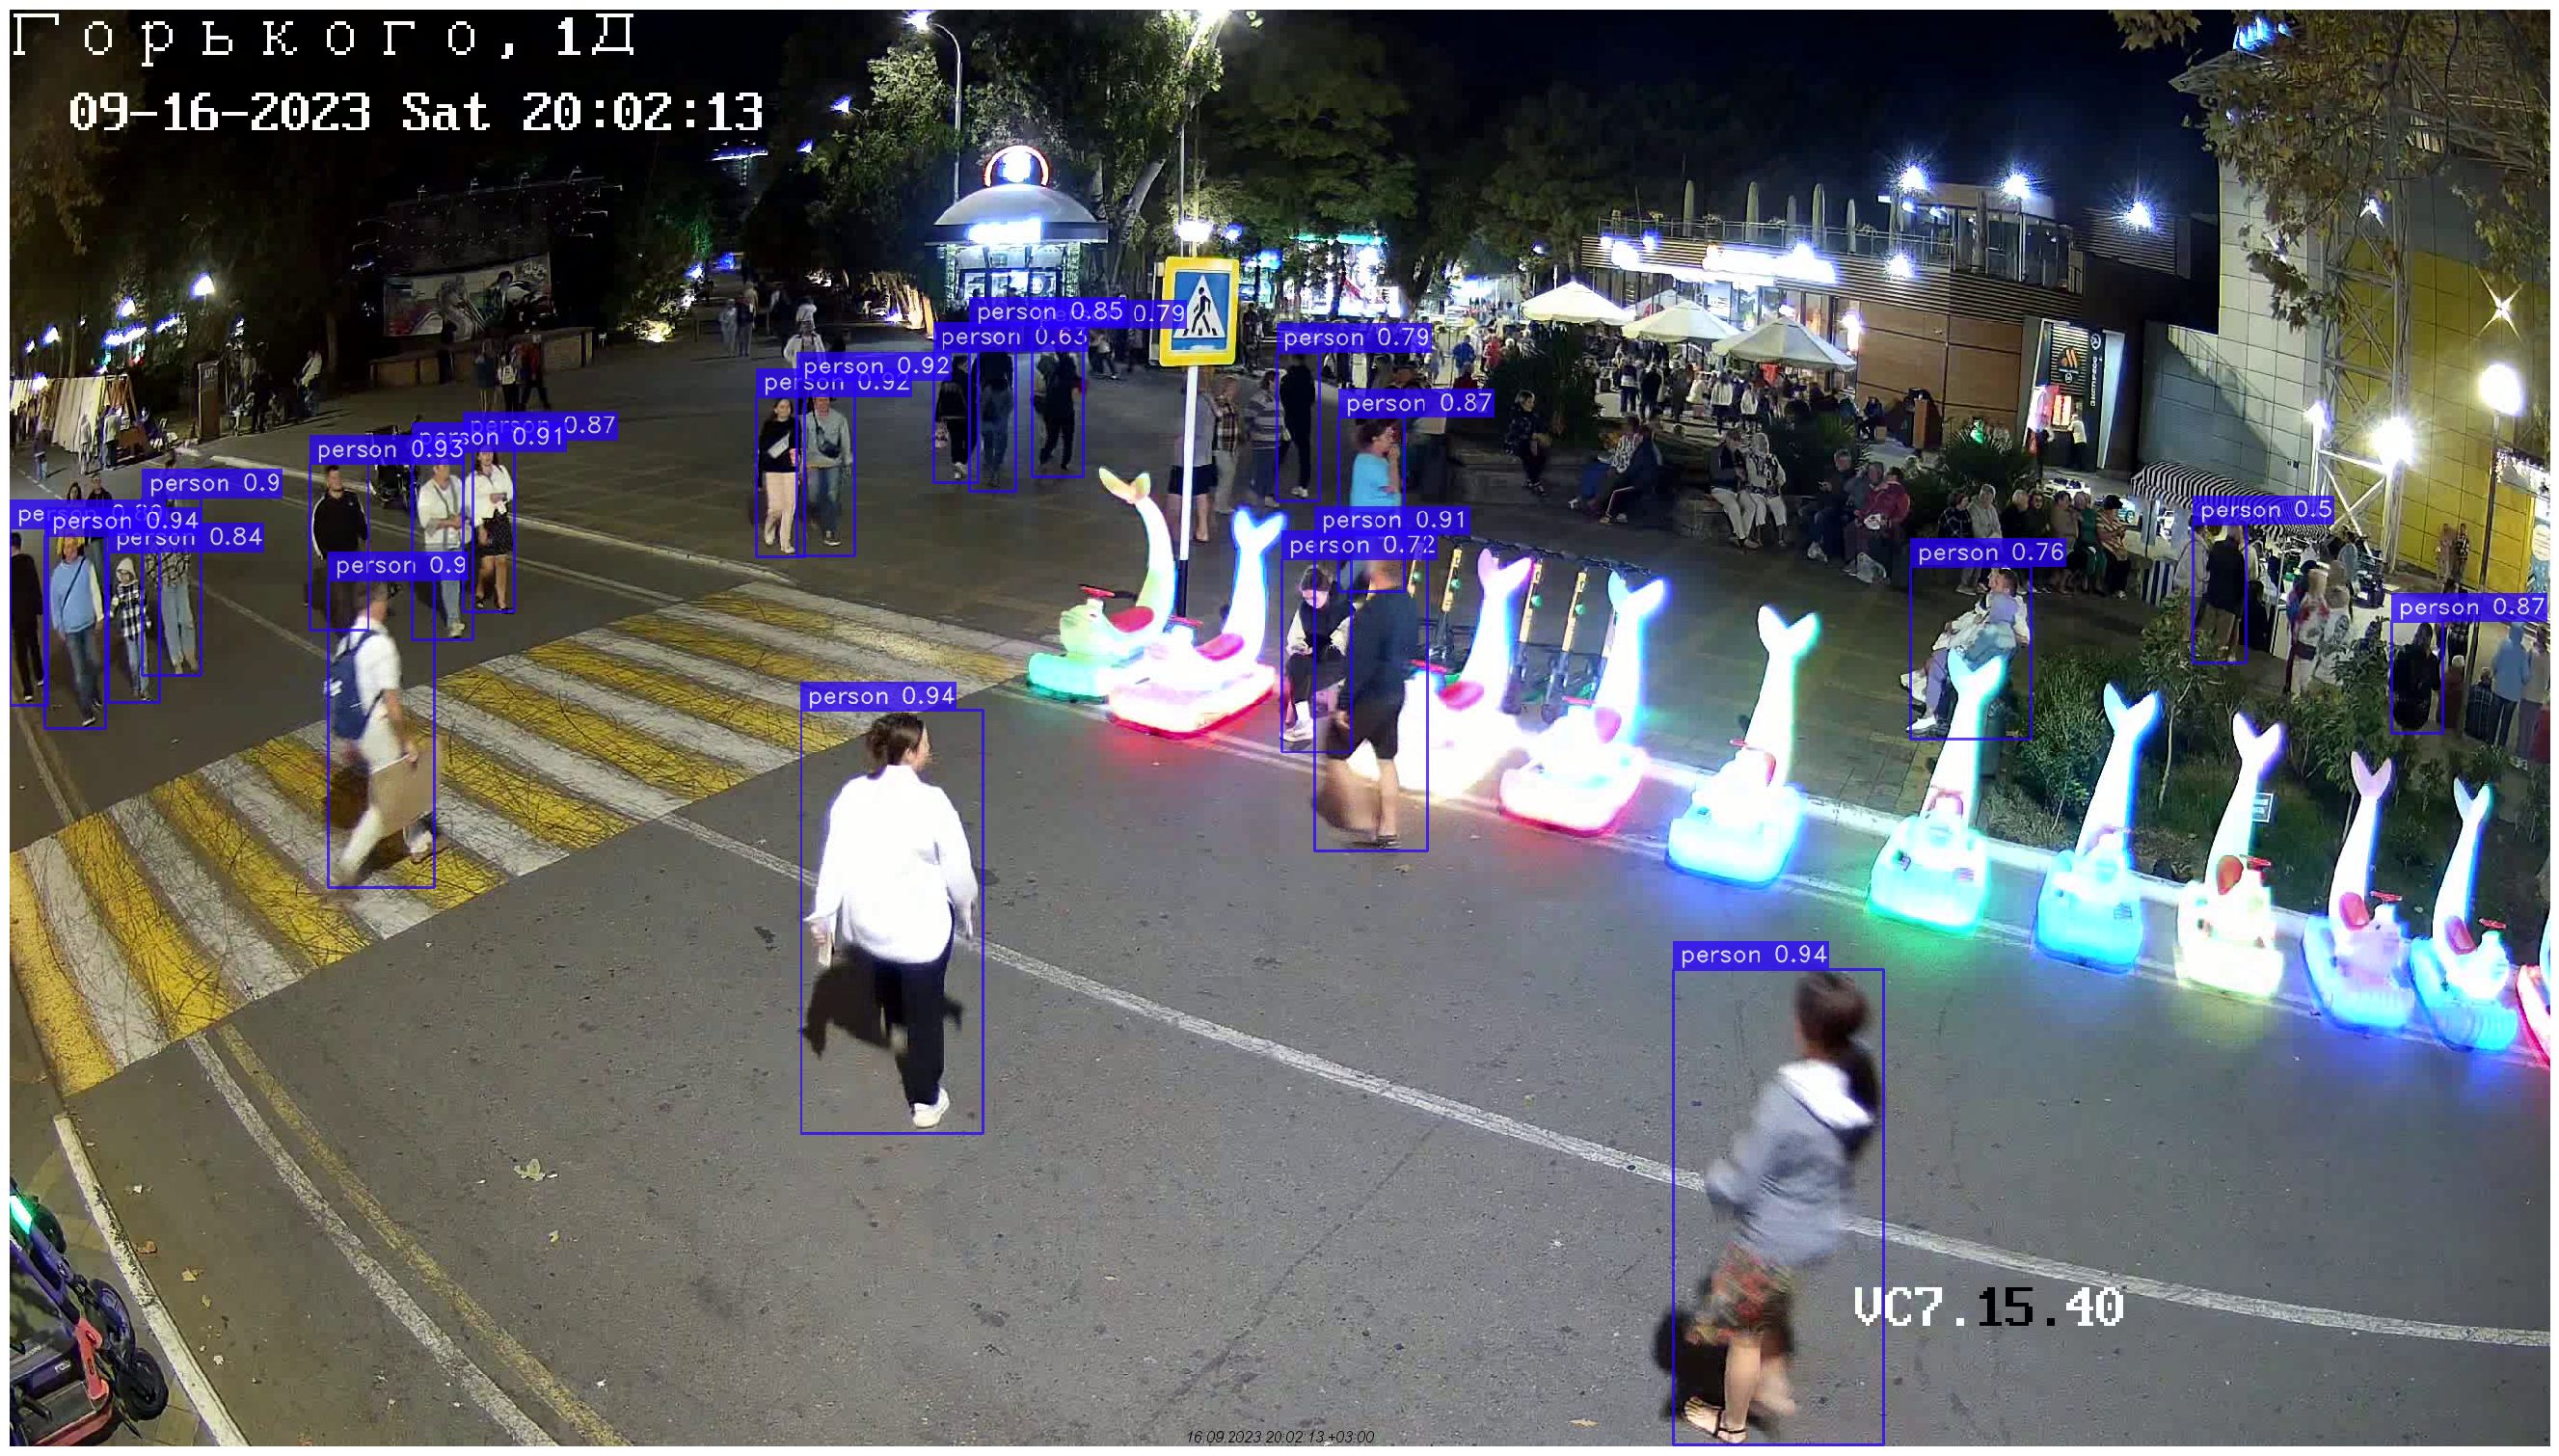

In [19]:
import super_gradients

model = models.get(
    model_to_train, 
    num_classes=len(dataset_params['classes']), 
    checkpoint_path="/media/storonkin/Work/projects/we-love-you-all/notebooks/checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth").cuda()

result = model.predict("/media/storonkin/Work/projects/we-love-you-all/notebooks/images/no_weapon/119.VC7.15.40 Горького, 1Д 2023-09-16 20-00-00_000+0300 [10m0s]-00167.png",fuse_model=True).show()

In [18]:
result

ImagesDetectionPrediction(_images_prediction_lst=[ImageDetectionPrediction(image=array([[[21, 23, 18],
        [ 9, 11,  6],
        [ 8, 10,  5],
        ...,
        [33, 25, 14],
        [39, 31, 20],
        [44, 36, 25]],

       [[10, 12,  7],
        [11, 13,  8],
        [ 8, 10,  5],
        ...,
        [32, 24, 13],
        [38, 30, 19],
        [43, 35, 24]],

       [[ 3,  5,  0],
        [11, 13,  8],
        [ 7,  9,  4],
        ...,
        [30, 22, 11],
        [36, 28, 17],
        [39, 31, 20]],

       ...,

       [[ 6,  1, 40],
        [ 6,  1, 40],
        [ 6,  1, 42],
        ...,
        [70, 74, 76],
        [76, 80, 82],
        [79, 83, 85]],

       [[ 4,  0, 38],
        [ 7,  2, 41],
        [ 8,  2, 46],
        ...,
        [68, 72, 74],
        [70, 74, 76],
        [72, 76, 78]],

       [[ 3,  0, 37],
        [ 7,  2, 41],
        [ 8,  2, 46],
        ...,
        [69, 73, 75],
        [63, 67, 69],
        [58, 62, 64]]], dtype=uint8), prediction

In [25]:
import torch


def process_video(input_file: str, output_file: str, batch_size: int) -> None:
    model = models.get(
    model_to_train, 
    num_classes=len(dataset_params['classes']), 
    checkpoint_path="/media/storonkin/Work/projects/we-love-you-all/notebooks/checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth").cuda()

    # We want to use cuda if available to speed up inference.
    model = model.to("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize video capture object
    cap = cv2.VideoCapture(input_file)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create video writer object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, fps, (frame_width, frame_height))

    while True:

        # Load frames by batch to increase performance
        frames = []
        for _ in range(batch_size):
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)

        if not frames:
            break

        frames_predictions = model.predict(frames, iou=0.7, conf=0.3)

        for frame_prediction in frames_predictions:
            out.write(frame_prediction.draw())

    # Release video capture and writer objects
    cap.release()
    out.release()

In [26]:
process_video("/media/storonkin/Work/projects/we-love-you-all/app/web/backend/video/short_test_2.mp4","out_1.mp4",1)

[2023-11-15 10:42:32] INFO - checkpoint_utils.py - Successfully loaded model weights from /media/storonkin/Work/projects/we-love-you-all/notebooks/checkpoints/yolo_nas_s/RUN_20231115_003732_749383/ckpt_best.pth EMA checkpoint.
[2023-11-15 10:42:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-15 10:42:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-15 10:42:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-15 10:42:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2023-11-15 10:42:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactiv